# LEGO Brick Classification with TensorFlow Lite Model Maker

This notebook follows and adapts the [Image classification with the TensorFlow Lite Model Maker](https://www.tensorflow.org/lite/models/modify/model_maker/image_classification) Google Collab tutorial, a step-by-step lesson on how to make a custom flower classifier model for mobile use. The [TFLite Model Maker](https://www.tensorflow.org/lite/models/modify/model_maker) library uses transfer learning to reduce the amount of training data requirements and cut training time. For the project’s purpose, this notebook creates a custom LEGO brick classification model by using 14 bricks from [Joost Hazelzet’s Images of 50 LEGO Bricks Kaggle Dataset](https://www.kaggle.com/datasets/joosthazelzet/lego-brick-images). After integrating the 14-brick Tensorflow Lite model with the Swift App, I plan to go beyond 50 bricks. As of right now, the model performs well when the inference is carried out in Python and with images that have plain backgrounds.

### **Steps:**


1. **Install and Import Packages**
2. **Load Input Data**
3. **Customize TensorFlow Model**
4. **Export TFLite Model**



## Step 1: Install and Import Packages

In [ ]:
!sudo apt -y install libportaudio2
!pip install -q tflite-model-maker

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  libportaudio2
0 upgraded, 1 newly installed, 0 to remove and 27 not upgraded.
Need to get 64.6 kB of archives.
After this operation, 215 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudio2 amd64 19.6.0-1 [64.6 kB]
Fetched 64.6 kB in 1s (65.8 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

In [ ]:
import os

import numpy as np

import tensorflow as tf
assert tf.__version__.startswith('2')

from tflite_model_maker import model_spec
from tflite_model_maker import image_classifier
from tflite_model_maker.config import ExportFormat
from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.image_classifier import DataLoader

import matplotlib.pyplot as plt

## Step 2: Load Input Data

The current LEGO dataset contains 14 classes with 800 images each.

The dataset has the following directory structure:

<pre>
<b>legos</b>
|__ <b>2357 brick corner</b>
    |______ 12357 brick corner 1x2x2 000L.png
    |______ 2357 brick corner 1x2x2 000R
    |______ ...
|__ <b>2420 plate corner</b>
    |______ 2420 plate corner 2x2 000L.png
    |______ 2420 plate corner 2x2 000R.png
    |______ ...
|__ <b>2780 Peg with friction</b>
    |______ 2780 Peg with friction 000L.png
    |______ 2780 Peg with friction 000R.png
    |______ ...
|__ <b>3001 brick</b>
    |______ 3001 brick 2x4 000L.png
    |______ 3001 brick 2x4 000R.png
    |______ ...
|__ <b>3002 brick</b>
    |______ 3002 brick 2x3 000L.png
    |______ 3002 brick 2x3 000R.png
    |______ ...
</pre>

In [ ]:
# Unzip LEGO datatset

!unzip legos.zip

In [ ]:
# LEGO dataset path

image_path = 'legos'

In [ ]:
# from_folder() method -> 
# assumes image data of the same class are in the same subdirectory and the subfolder name is the class name
# Currently, JPEG-encoded images and PNG-encoded images are supported

data = DataLoader.from_folder(image_path)

In [ ]:
train_data, rest_data = data.split(0.8) # training data (80%)
validation_data, test_data = rest_data.split(0.5) # validation data (10%, optional) and testing data (10%).

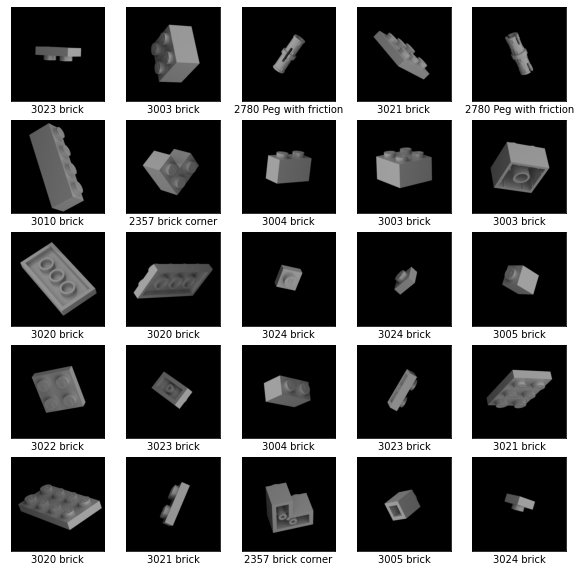

In [ ]:
# Show 25 image examples with labels:

plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(data.gen_dataset().unbatch().take(25)):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)
  plt.xlabel(data.index_to_label[label.numpy()])
plt.show()

## Step 3: Customize the TensorFlow Model


In [ ]:
# Default model is EfficientNet-Lite0

model = image_classifier.create(train_data, validation_data=validation_data)

# Change Model:
# model = image_classifier.create(train_data, model_spec=model_spec.get('mobilenet_v2'), validation_data=validation_data)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2_2 (Hub  (None, 1280)             3413024   
 KerasLayerV1V2)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 14)                17934     
                                                                 
Total params: 3,430,958
Trainable params: 17,934
Non-trainable params: 3,413,024
_________________________________________________________________
None
Epoch 1/5
280/280 [==============================] - 70s 243ms/step - loss: 1.5941 - accuracy: 0.5728 - val_loss: 1.2385 - val_accuracy: 0.7429
Epoch 2/5
280/280 [==============================] - 68s 242ms/step - loss: 1.2265 - acc

Have a look at the detailed model structure.

In [ ]:
# Model structure

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2_2 (Hub  (None, 1280)             3413024   
 KerasLayerV1V2)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 14)                17934     
                                                                 
Total params: 3,430,958
Trainable params: 17,934
Non-trainable params: 3,413,024
_________________________________________________________________


In [ ]:
# Evaluate model results

loss, accuracy = model.evaluate(test_data)

35/35 [==============================] - 21s 176ms/step - loss: 1.0562 - accuracy: 0.8330


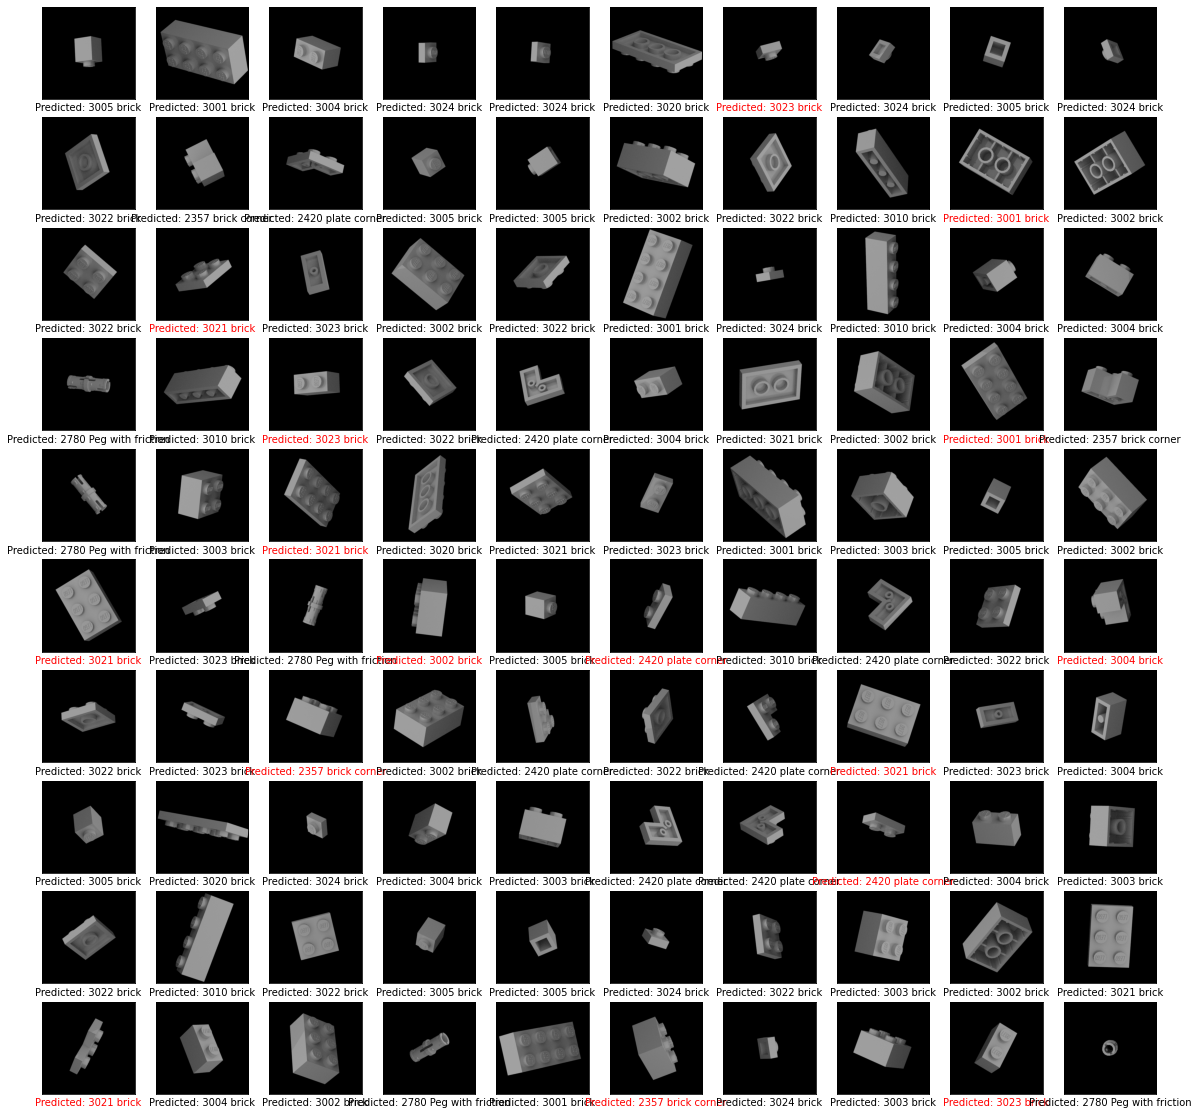

In [ ]:
# Plot 100 test images
# red = wrong predicted results

# A helper function that returns 'red'/'black' depending on if its two input
# parameter matches or not.
def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

# Then plot 100 test images and their predicted labels.
# If a prediction result is different from the label provided label in "test"
# dataset, we will highlight it in red color.
plt.figure(figsize=(20, 20))
predicts = model.predict_top_k(test_data)
for i, (image, label) in enumerate(test_data.gen_dataset().unbatch().take(100)):
  ax = plt.subplot(10, 10, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)

  predict_label = predicts[i][0][0]
  color = get_label_color(predict_label,
                          test_data.index_to_label[label.numpy()])
  ax.xaxis.label.set_color(color)
  plt.xlabel('Predicted: %s' % predict_label)
plt.show()

## Step 5: Export to TensorFlow Lite Model

In [ ]:
model.export(export_dir='.')

/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [ ]:
model.export(export_dir='.', export_format=ExportFormat.LABEL)

In [ ]:
model.evaluate_tflite('model.tflite', test_data)

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
@misc{tensorflow2015-whitepaper,
title={ {TensorFlow}: Large-Scale Machine Learning on Heterogeneous Systems},
url={https://www.tensorflow.org/},
note={Software available from tensorflow.org},
author={
    Mart\'{i}n~Abadi and
    Ashish~Agarwal and
    Paul~Barham and
    Eugene~Brevdo and
    Zhifeng~Chen and
    Craig~Citro and
    Greg~S.~Corrado and
    Andy~Davis and
    Jeffrey~Dean and
    Matthieu~Devin and
    Sanjay~Ghemawat and
    Ian~Goodfellow and
    Andrew~Harp and
    Geoffrey~Irving and
    Michael~Isard and
    Yangqing Jia and
    Rafal~Jozefowicz and
    Lukasz~Kaiser and
    Manjunath~Kudlur and
    Josh~Levenberg and
    Dandelion~Man\'{e} and
    Rajat~Monga and
    Sherry~Moore and
    Derek~Murray and
    Chris~Olah and
    Mike~Schuster and
    Jonathon~Shlens and
    Benoit~Steiner and
    Ilya~Sutskever and
    Kunal~Talwar and
    Paul~Tucker and
    Vincent~Vanhoucke and
    Vijay~Vasudevan and
    Fernanda~Vi\'{e}gas and
    Oriol~Vinyals and
    Pete~Warden and
    Martin~Wattenberg and
    Martin~Wicke and
    Yuan~Yu and
    Xiaoqiang~Zheng},
  year={2015},
}